# Содержание


- [Предварительная обработка данных](#1)
    - [Импорт набора данных](#11)
    - [Поиск пропусков](#12)
    - [Поиск дубликатов](#13)
    - [Приведение типов данных](#14)
    - [Определение сбалансированности](#15)
    - [Поиск выбросов](#22)
- [Создание и обучение модели](#3)
    - [Подготовка данных для обучения](#31)
    - [Обучение моделей](#33)
        - [Ансамблевые модели: адаптивный бустинг](#334)

# Предварительная обработка данных <a id="1"></a>

Основной целью данной части является осмотр данных с целью:
* Создания его описания;
* Поиска и устранения пропусков в данных;
* Приведение столбцов к истинным форматам данных;
* Поиск и устранение явных и неявных дубликатов данных;
* Поиск и устранение выбросов в данных, если таковые присутствуют;
* Определить, являются ли классы, сформированные целевой переменной, сбалансированными.

## Импорт набора данных <a id="11"></a>

В начале выполнения всей работы импортируем все необходимые библиотеки:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Перед началом осмотра данных их необходимо как-то извлечь из CSV-файла (Comma-Separated Values). Для этого существует библиотека **Pandas** для языка Python, которая предоставляет широкий спектр инструментов для аналитики данных. <br>
Для начала, необходимо импортировать библиотеку **Pandas** в Python и загрузить в датафрейм *(так называется сущность для хранения данных в Pandas)* из CSV-файла:

In [2]:
df = pd.read_csv("smoking_driking_dataset_Ver01.csv")

Далее, чтобы убедиться в том, что данные были импортированы успешно, попробуем вывести первые 5 строк из датафрейма. Для этого в Pandas существует команда `.head()`.

In [3]:
df.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


Исходя из полученной после выполнения команды таблицы, можно сделать вывод о том, что импорт данных проведён успешно и можно приступать к дальнейшим этапам.

## Поиск пропусков <a id="12"></a>

Далее, перейдём уже непосредственно к предварительной обработки данных. И на первом этапе изучим набор данных на наличие пропусков среди данных.

При поиске пустых данных зачастую применяют специальный метод `.isna()`, который покажет, присутствуют ли пустые значения в каждом из столбцов.

Однако проблема использования данного метода заключается в том, что он просматривает всю таблицу и если где-то отсутствует хоть одно значение, то он выведет *True*, иначе *False*. Если же необходимо посчитать количество пропущенных значений, то вместе с исходным методом применяют `.sum()`.

Таким образом, итоговая команда выглядит как показано ниже:

In [4]:
df.isna().sum()

sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64

Исходя из полученного результата, можно сделать вывод о том, что в исходном наборе данных **отсутствуют пустые значения**.

## Поиск дубликатов <a id="13"></a>

Следующим этапом при обработке данных идет поиск дубликатов. Обычно он делиться на 2 типа: *поиск явных дубликатов* и *поиск неявных дубликатов*. Рассмотрим **первый случай**.

Для поиска явных дубликатов применяется метод `.duplicated()`, который ищет все дубликаты среди строк. По умолчанию данный метод признаёт дубликатами те строки, которые полностью повторяют уже встречавшиеся в наборе данных. Т.е. метод, как и в случае с методом `.isna()`, возвращает значение либо **True**, либо **False**. Поэтому для понимания количества дубликатов добавляют, как и в предыдущем случае, функцию `.sum()`. 

In [5]:
df.duplicated().sum()

26

Как можно заметить, результат выполнения комбинации данных функций показал наличие 26 полностью повторяющихся строк. Для того, чтобы оценить, насколько сильно данные 26 строк влияют на общую картину данных, выведем общую длину набора данных при помощи встроенной функции `len()`.

In [6]:
print(f"Общий объем данных: {len(df)}")
print(f"Процент продублированных данных: {df.duplicated().sum() / len(df):.5f}")

Общий объем данных: 991346
Процент продублированных данных: 0.00003


Как можно заметить, процентное отношение дубликатов к общему объему данных невелико, и по идеи можно и опустить факт наличия дубликатов в данных. Однако, для чистоты эксперимента от дубликатов необходимо избавиться. Для этого в **Pandas** реализован метод `.drop_duplicates()`, который в качестве результата своего выполнения возвращает датафрейм без дубликатов.

Также, поскольку после удаления продублированных строк их индексы также будут удалены, то необходимо использовать метод `.reset_index()`, который проиндексирует все строки заново.

Таким образом, для того, чтобы убедится в том, что продублированные строки удалены из общего объема данных, выполним следующий набор команд.

In [7]:
print(f"Количество дубликатов до удаления: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Количество дубликатов после удаления: {df.duplicated().sum()}")

Количество дубликатов до удаления: 26
Количество дубликатов после удаления: 0


Далее, рассмотрим способ поиска **неявных дубликатов**. Неявными дубликатами являются разного рода ошибки в столбцах с данными (грамматические ошибки, опечатки и т.д.). Для поиска таких дубликатов применяется метод `.unique()` для каждого столбца датафрейма. Также, чтобы дубликаты было проще найти, применяют сортировку при помощи метода `.sort()`.

В итоге, применим данные методы и оценим набор данных на наличие неявных дубликатов.


In [8]:
for col in df:
    print(col, end="\n")
    vals = df[col].unique()
    vals.sort()
    print(vals, "\n")

sex
['Female' 'Male'] 

age
[20 25 30 35 40 45 50 55 60 65 70 75 80 85] 

height
[130 135 140 145 150 155 160 165 170 175 180 185 190] 

weight
[ 25  30  35  40  45  50  55  60  65  70  75  80  85  90  95 100 105 110
 115 120 125 130 135 140] 

waistline
[  8.   27.   30.   32.   35.   40.   42.   43.   48.   49.   50.   50.3
  50.5  51.   51.1  51.2  51.5  51.6  51.8  52.   52.1  52.4  52.5  52.6
  53.   53.1  53.2  53.4  53.5  53.6  53.8  54.   54.1  54.2  54.3  54.4
  54.5  54.6  54.8  54.9  55.   55.1  55.2  55.3  55.4  55.5  55.6  55.7
  55.8  55.9  56.   56.1  56.2  56.3  56.4  56.5  56.6  56.7  56.8  56.9
  57.   57.1  57.2  57.3  57.4  57.5  57.6  57.7  57.8  57.9  58.   58.1
  58.2  58.3  58.4  58.5  58.6  58.7  58.8  58.9  59.   59.1  59.2  59.3
  59.4  59.5  59.6  59.7  59.8  59.9  60.   60.1  60.2  60.3  60.4  60.5
  60.6  60.7  60.8  60.9  61.   61.1  61.2  61.3  61.4  61.5  61.6  61.7
  61.8  61.9  62.   62.1  62.2  62.3  62.4  62.5  62.6  62.7  62.8  62.9
  63.   63.1  6

Проанализировав полученные результаты можно сделать вывод о том, что неявных дубликатов в исходном наборе данных не наблюдается.

## Приведение типов данных <a id="14"></a>

В процессе поиска неявных дубликатов было замечено, что многие столбцы исходного набора данных имеют неверный тип данных. В связи с этим, повторно выведем основную информацию о датафрейме при помощи метода `.info()`.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 991320 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991320 non-null  object 
 1   age               991320 non-null  int64  
 2   height            991320 non-null  int64  
 3   weight            991320 non-null  int64  
 4   waistline         991320 non-null  float64
 5   sight_left        991320 non-null  float64
 6   sight_right       991320 non-null  float64
 7   hear_left         991320 non-null  float64
 8   hear_right        991320 non-null  float64
 9   SBP               991320 non-null  float64
 10  DBP               991320 non-null  float64
 11  BLDS              991320 non-null  float64
 12  tot_chole         991320 non-null  float64
 13  HDL_chole         991320 non-null  float64
 14  LDL_chole         991320 non-null  float64
 15  triglyceride      991320 non-null  float64
 16  hemoglobin        991320 

После сравнения типов столбцов с их значениями было получено:
* Столбец `hear_left` преобразовать в `int`;
* Столбец `hear_right` преобразовать в `int`;
* Столбец `SBP` преобразовать в `int`;
* Столбец `DBP` преобразовать в `int`;
* Столбец `BLDS` преобразовать в `int`;
* Столбец `DBP` преобразовать в `int`;
* Столбец `tot_chole` преобразовать в `int`;
* Столбец `HDL_chole` преобразовать в `int`;
* Столбец `LDL_chole` преобразовать в `int`;
* Столбец `triglyceride` преобразовать в `int`;
* Столбец `urine_protein` преобразовать в `int`;
* Столбец `SGOT_AST` преобразовать в `int`;
* Столбец `SGOT_ALT` преобразовать в `int`;
* Столбец `gamma_GTP` преобразовать в `int`;
* Столбец `SMK_stat_type_cd` преобразовать в `int`.

Для того, чтобы преобразовать столбец к другому типу данных в **Pandas** реализован специальный метод `.astype()`, который преобразует любой объект, созданный библиотекой Pandas, к требуемому типу данных.

Таким образом, для того, чтобы преобразовать все обнаруженные столбцы, необходимо выполнить следующие строки кода:

In [10]:
cols = [
    "hear_left",
    "hear_right",
    "SBP",
    "DBP",
    "BLDS",
    "DBP",
    "tot_chole",
    "HDL_chole",
    "LDL_chole",
    "triglyceride",
    "urine_protein",
    "SGOT_AST",
    "SGOT_ALT",
    "gamma_GTP",
    "SMK_stat_type_cd",
]
for col in cols:
    df[col] = df[col].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 991320 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991320 non-null  object 
 1   age               991320 non-null  int64  
 2   height            991320 non-null  int64  
 3   weight            991320 non-null  int64  
 4   waistline         991320 non-null  float64
 5   sight_left        991320 non-null  float64
 6   sight_right       991320 non-null  float64
 7   hear_left         991320 non-null  int32  
 8   hear_right        991320 non-null  int32  
 9   SBP               991320 non-null  int32  
 10  DBP               991320 non-null  int32  
 11  BLDS              991320 non-null  int32  
 12  tot_chole         991320 non-null  int32  
 13  HDL_chole         991320 non-null  int32  
 14  LDL_chole         991320 non-null  int32  
 15  triglyceride      991320 non-null  int32  
 16  hemoglobin        991320 

Помимо этого, на этапе поиска неявных дубликатов было обнаружено, что столбцы `sex` и `DRK_YN` являются биномиальными параметрами, т.е. существует всего лишь 2 возможных значения в данных столбцах: male/female и Y/N соответственно.

В связи с этим было принято решения изменить данные из этих двух столбцов, заменив их на 1 и 0. Пусть в столбце `sex` будет произведена следующая замена: `male -> 0, female -> 1`, а в столбце `DRK_YN` следующая: `Y -> 1, N -> 0`.

Для того, чтобы произвести данную замену в **Pandas** реализован метод `replace()`, который заменяет выбранное на то, которое требуется. Таким образом, произведём замену данных в выбранных столбцах.

In [11]:
df["DRK_YN"] = df["DRK_YN"].replace("N", 0).replace("Y", 1)
df["sex"] = df["sex"].replace("Male", 0).replace("Female", 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 991320 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991320 non-null  int64  
 1   age               991320 non-null  int64  
 2   height            991320 non-null  int64  
 3   weight            991320 non-null  int64  
 4   waistline         991320 non-null  float64
 5   sight_left        991320 non-null  float64
 6   sight_right       991320 non-null  float64
 7   hear_left         991320 non-null  int32  
 8   hear_right        991320 non-null  int32  
 9   SBP               991320 non-null  int32  
 10  DBP               991320 non-null  int32  
 11  BLDS              991320 non-null  int32  
 12  tot_chole         991320 non-null  int32  
 13  HDL_chole         991320 non-null  int32  
 14  LDL_chole         991320 non-null  int32  
 15  triglyceride      991320 non-null  int32  
 16  hemoglobin        991320 

Таким образом, после выполнения преобразования столбцов исходного датафрейма, используются всего лишь два типа данных: **int** и **float**

## Определение сбалансированности <a id="15"></a>

В задаче классификации данные называются **несбалансированными** (imbalanced data), если в обучающей выборке доли объектов разных классов существенно различаются, также говорят, что "*классы не сбалансированы*"

Для того, чтобы выяснить, являются ли данные сбалансированными, посчитаем количество людей, относящихся к первому и второму классу, а также выведем их процентное соотношение ко всем данным.

In [12]:
dont_drink = len(df[df["DRK_YN"] == 0])
drink = len(df[df["DRK_YN"] == 1])
print(
    f"""
Количество непьющих: {dont_drink}, их процент от общего числа: {dont_drink/len(df):.4f} 
Количество пьющих: {drink}, их процент от общего числа: {drink/len(df):.4f}"""
)


Количество непьющих: 495844, их процент от общего числа: 0.5002 
Количество пьющих: 495476, их процент от общего числа: 0.4998


Как видно из полученных значений, данные являются отлично сбалансированными. Следовательно, можно завершать этап предварительной обработки данных и переходить в следующему этапу.

## Поиск выбросов <a id="22"></a>

После преобразования всех типов данных, необходимо оценить исходные данные на наличие выбросов. **Выбросами** в данных являются те значения, которые сильно отличаются от большинства других значений в наборе данных. Если в исходном наборе данных присутствуют выбросы, то от них лучше избавиться, поскольку они могут вносить существенные изменения в результаты анализа, а в дальнейшем и на обучение моделей.

Существует множество методов обнаружения, но в самым простым из них является **экстремальный анализ данных** (англ. *extreme value analysis*). При таком анализе не применяются какие-либо специальные статистические методы. Алгоритм использования таков:
1) Визуализировать данные, используя диаграммы и гистограммы для нахождения экстремальных значений;
2) Задействовать распределение, например Гауссовское, и найти значения, чье стандартное отклонение отличается в 2-3 раза от математического ожидания;
3) Отфильтровать предполагаемые выбросы из обучающей выборки и оценить работу модели.

В соответствии с первым шагом предложенного алгоритма визуализируем данные всех интересующих столбцов. Обычно, для этого импортируют библиотеку **Seaborn** и используют метод `.pairplot()`. По умолчанию эта функция создаст сетку осей таким образом, что данные из каждого числового столбца исходного датафрейма будут распределены как по оси X, так и по оси Y. Диагональные графики же показывают гистограммы распределений данных из численных столбцов

Однако, поскольку исходный датафрейм состоит из 25 столбцов, то создание такой диаграммы может занять очень продолжительное время. Поэтому, было принято решение построить для начала графики только тех столбцов, в которых могут быть выбросы. В качестве функции для построение графика была выбрана `.boxplot()`, которая рисует диаграмму 'ящик с усами', который отлично показывает наличие или отсутствие выбросов.

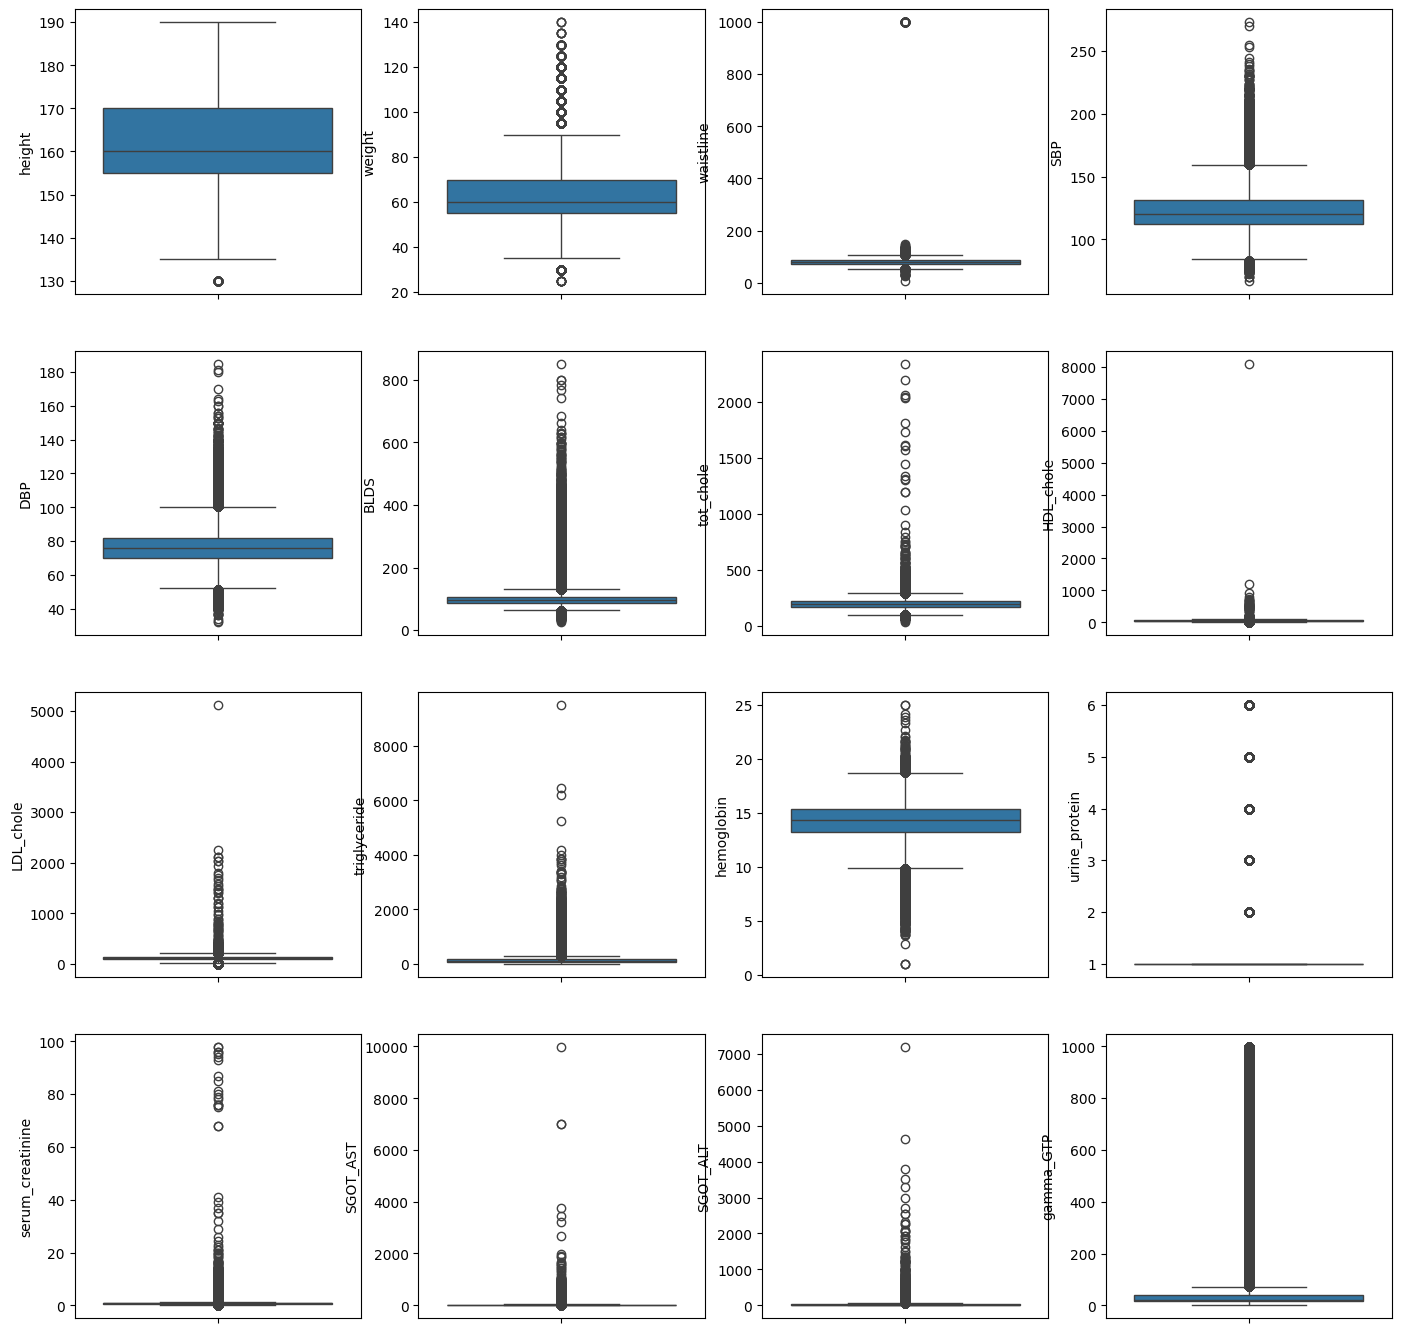

In [13]:
columns = [
    "height",
    "weight",
    "waistline",
    "SBP",
    "DBP",
    "BLDS",
    "tot_chole",
    "HDL_chole",
    "LDL_chole",
    "triglyceride",
    "hemoglobin",
    "urine_protein",
    "serum_creatinine",
    "SGOT_AST",
    "SGOT_ALT",
    "gamma_GTP",
]
rows, cols = 4, 4
plt.figure(figsize=(17, 17))
for i in range(len(columns)):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(df[columns[i]])

Исходя из полученных графиков можно заметить, что не все столбцы имеют выбросы. Также, можно создать список столбцов, которые необходимо рассмотреть отдельно:
* Waistline
* HDL_chole
* LDL_chole
* triglyceride
* SGOT_AST
* SGOT_ALT


Начнём с рассмотрения первого из них.


### Waistline

Выведем 'ящик с усами' для первого столбца из списка. Для этого также воспользуемся методом `.boxplot()`

<Axes: ylabel='waistline'>

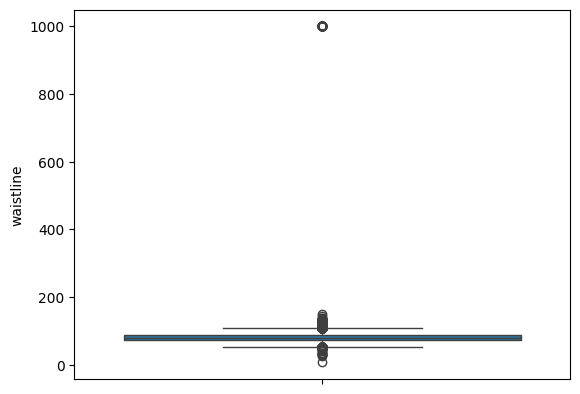

In [14]:
sns.boxplot(df["waistline"])

Как видно из полученного рисунка, среди данных присутствует явный выброс. Попробуем найти строку с такими данными среди исходного датафрейма.

In [15]:
df[df["waistline"] > 500].head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
11230,1,30,160,55,999.0,1.0,1.0,1,1,100,...,91,180,12.6,1,0.8,12,8,11,1,0
23779,1,25,160,60,999.0,0.9,0.9,1,1,118,...,160,234,14.1,3,1.1,22,10,14,1,0
30711,1,25,160,55,999.0,0.8,1.0,1,1,102,...,99,80,11.1,1,0.6,14,12,10,1,0
59546,1,25,160,65,999.0,1.5,1.5,1,1,106,...,90,306,11.2,1,0.6,14,14,10,1,0
67877,1,30,155,60,999.0,1.0,1.5,1,1,114,...,146,280,10.4,1,0.8,15,6,10,1,0


Как видно, таких данных получилось аж 57 значений. Теперь нужно решить, как избавиться от данной проблемы. Поскольку удалить 57 строк было бы невежественно, то изменим данные значения на среднее арифметическое значение данного столбца, исключив при этом данные 57 строк.

Для нахождения среднего значения столбца воспользуемся методом `.mean` из библиотеки **NumPy**.

In [16]:
df.loc[df["waistline"] > 500, "waistline"] = np.mean(
    df.loc[(df["waistline"] < 500)]["waistline"].to_numpy()
)

Далее, проверим ещё раз данные из этого столбца, чтобы оценить наличие выбросов в данных.

<Axes: ylabel='waistline'>

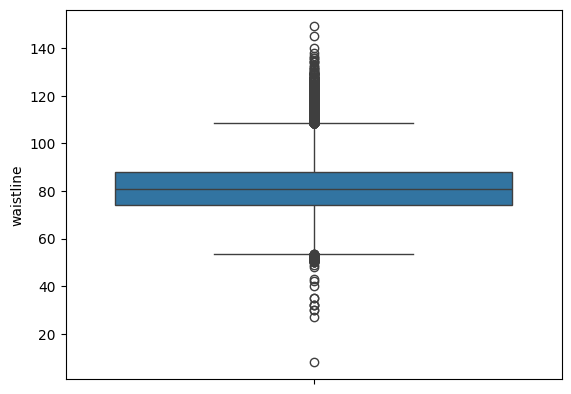

In [17]:
sns.boxplot(df["waistline"])

Видно, что теперь выброс происходит в другую сторону, а именно в меньшую сторону. Посмотрим, сколько таких данных всего:

In [18]:
df[df["waistline"] < 20].head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
796004,1,75,140,40,8.0,0.1,0.4,1,1,120,...,85,256,11.0,1,0.8,59,67,60,1,0


Была обнаружена всего лишь одна строка, следовательно, можно без угрызения совести отфильтровать данные таким образом, чтобы данное значение не попало в отфильтрованный датафрейм. Фильтрация происходит благодаря функции `.loc()`, которая предоставляет доступ к группе строк и столбцов по меткам или логическому выражению. Также, выведем диаграмму еще раз, чтобы посмотреть наличие выбросов в данных. 

<Axes: ylabel='waistline'>

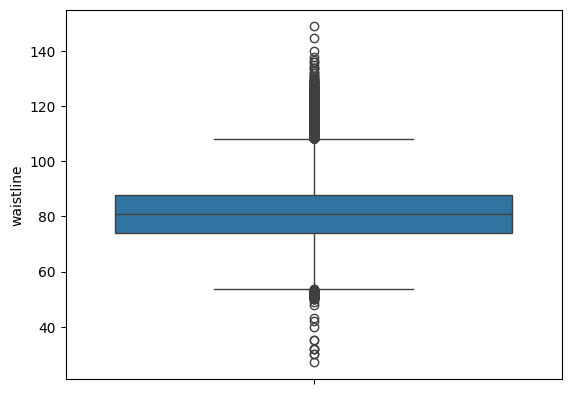

In [19]:
df = df.loc[df["waistline"] > 20]
sns.boxplot(df["waistline"])

### HDL_chole

Также, как и в предыдущий раз, для начала выведем диаграмму 'ящик с усами' при помощи метода `.boxplot()`, который поможет оценить наличие выбросов в данных.

<Axes: ylabel='HDL_chole'>

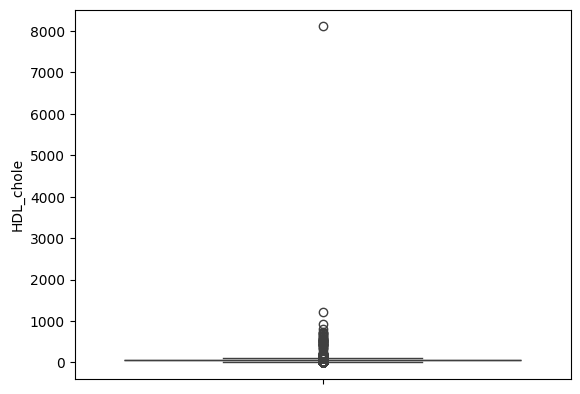

In [20]:
sns.boxplot(df["HDL_chole"])

Из приведённого выше графика наглядно видно, что присутствует выброс в данных. Попробуем выяснить количество данных с таким выбросом.

In [21]:
df[df["HDL_chole"] > 2000].head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
7075,1,20,160,55,67.0,0.3,0.5,1,1,105,...,5119,9490,14.0,1,0.8,21,15,18,1,0


Была обнаружена всего лишь одна строка, значит, мы можем спокойно от неё избавится, отфильтровав исходный датафрейм.

In [22]:
df = df.loc[df["HDL_chole"] < 2000]

### LDL_chole

Для данного столбца, как и в предыдущих двух случаях, выведем диаграмму и посмотрим на наличие выбросов.

<Axes: ylabel='LDL_chole'>

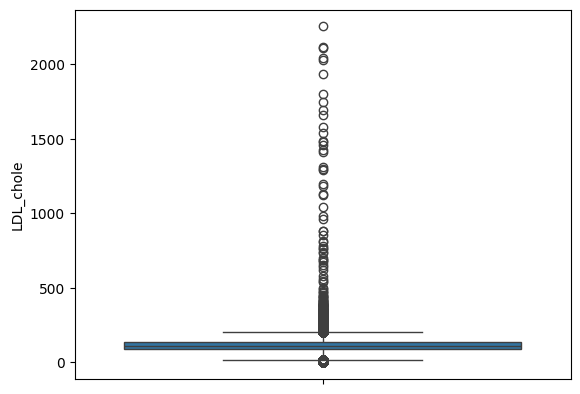

In [23]:
sns.boxplot(df["LDL_chole"])

При сравнении данного графика с тем, который был представлен изначально, можно заметить, что выброс, который был в данном столбце, ушел при устранении выбросов в других столбцах. Значит, можно переходит к следующему столбцу.

### Triglyceride

Посмотрим на 'ящик с усами' для данного столбца.

<Axes: ylabel='triglyceride'>

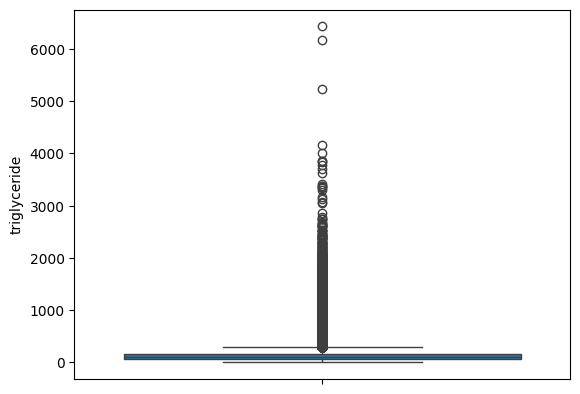

In [24]:
sns.boxplot(df["triglyceride"])

Из полученной диаграммы видно, что в данных содержатся выбросы. Попробуем оценить количество строк с выбросом.

In [25]:
df[df["triglyceride"] > 5000].head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
81001,1,40,155,75,88.5,0.6,0.7,1,1,136,...,70,5236,17.3,3,0.6,28,18,28,3,1
105334,0,55,165,55,79.0,0.6,0.6,1,1,150,...,39,6430,16.3,1,0.5,19,16,477,3,1
220459,0,40,165,90,103.0,1.2,1.5,1,1,118,...,54,6173,19.3,1,0.6,26,43,169,3,0


Всего таких строк имеется 3 штуки. Следовательно, удалим данные строки из исходного набора данных.

In [26]:
df = df.loc[df["triglyceride"] < 5000]

### SGOT_AST и SGOT_ALT

Также, как и в предыдущие разы, посмотрим на диаграмму, полученную после выполнения метода `.boxplot()` для обоих столбцов.

<Axes: ylabel='SGOT_ALT'>

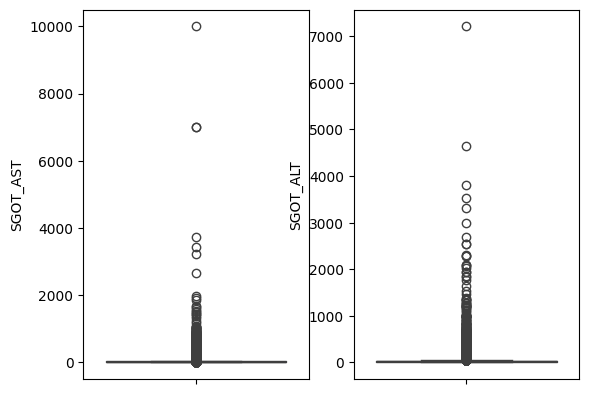

In [27]:
plt.subplot(1, 2, 1)
sns.boxplot(df["SGOT_AST"])
plt.subplot(1, 2, 2)
sns.boxplot(df["SGOT_ALT"])

Явно видны по 2 точки в данных, которые являются выбросами. Оценим количество таких строк.

In [28]:
df[(df["SGOT_AST"] > 6000) | (df["SGOT_ALT"] > 4000)]

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
536962,0,50,170,45,66.0,0.9,0.7,1,1,96,...,69,67,15.4,1,1.2,9999,380,419,3,1
609072,1,40,170,70,76.0,1.0,1.0,1,1,123,...,71,159,15.5,1,0.9,1052,7210,270,1,1
642779,0,40,175,75,82.0,1.0,1.2,1,1,160,...,62,362,15.7,4,1.3,7000,3307,280,2,1
804428,0,55,170,70,90.0,1.0,1.0,1,1,100,...,52,120,15.9,4,2.2,7000,3807,429,1,0
808591,0,65,165,65,81.0,0.6,0.7,1,1,135,...,112,113,13.3,1,1.0,43,4633,9,3,1


Видно, что таких строк всего лишь 5 штук. Поскольку их слишком мало, то удалим их.

In [29]:
df = df[(df["SGOT_AST"] < 6000)]
df = df[(df["SGOT_ALT"] < 4000)]

<Axes: ylabel='SGOT_ALT'>

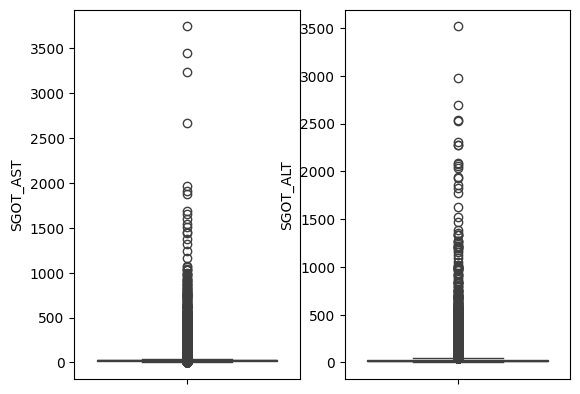

In [30]:
plt.subplot(1, 2, 1)
sns.boxplot(df["SGOT_AST"])
plt.subplot(1, 2, 2)
sns.boxplot(df["SGOT_ALT"])

# Создание и обучение модели <a id="3"></a>

На этом шаге происходит обучение модели. Обучение моделей машинного обучения происходит итерационно - пробуются различные модели, перебираются гиперпараметры, сравниваются значения выбранной метрики и выбирается лучшая комбинация.


## Подготовка данных для обучения <a id="31"></a>

Вначале нужно определить, на каких данных будет обучаться модель, а на каких тестироваться. **Традиционный подход** - это разделение исходного набора данных на 3 части (обучение, валидация и тестирование) с пропорции 60/20/20. В данном случае обучающая выборка используется для обучения модели, а валидация и тестирование для получения значения метрики без эффекта переобучения.

Однако существует и другой подход к разбиению данных - разделение на 2 части (обучение и тестирование) по правилу 80-20 (80% тренировочный, 20% тестовый). Зачастую данный метод применяется в тех случаях, когда отсутствует достаточное количество данных как в обучающем, так и в проверочном наборе.  

Перед тем как начать разбивать данные необходимо выделить из исходного набора данных целевую переменную (столбец `DRK_YN`) и сохранить её в отдельную переменную. Ниже приведён код разделения:

In [31]:
x = df.drop(columns=["DRK_YN"], axis=1)
y = df["DRK_YN"]

В ходе выполнения данной работы будет использован подход с разделением исходной выборки на 2 части с пропорцией 80-20, поскольку данный способ является самым популярным способом разбиения данных. Для того, чтобы разбить данные таким образом, существует специальный метод `train_test_split` в библиотеке `scikit-learn`.

In [32]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

### Ансамблевые модели: адаптивный бустинг <a id="335"></a>

У каждой модели машинного обучения есть некоторый предел, до которого можно повышать точность, а дальше начинается переобучение и модель уже физически не может предсказать точнее, чем заложено в её природе. Эта природа определяется не только моделью, а связкой модели, т.е. математическим аппаратом и данными, которые эта модель пытается преобразовать. Однако точность работы одной конкретной модели не является пределом при решении задач машинного обучения.

Когда с этим столкнулись первые исследователи они обратились к математической статистике и выяснили, что если взять несколько однородных моделей и среднее их предсказание, но при этом модели обучены на немного разных выборках, то получится, что ошибка среднего равна $\sqrt{n}$, где $n$ это количество моделей. И ошибка выходит меньше за счёт того, что мы берём несколько одинаковых моделей. **Цель** ансамблевых методов - объединить различные классификаторы в метаклассификатор, который обладает лучшей эффективностью обобщения, чем каждый индивидуальный классификатор сам по себе.

В качестве примера ансамблей можно привести феномен "Мудрость толпы". В 1906 году Френсис Гальтон предлагал посетителям ярмарки угадать вес живого быка. Всего в эксперименте приняли участие около 800 человек. Каждый из участников должен был написать свой ответ на карточке и передать её Гальтону. Затем он сложил все ответы и разделил их на общее количество участников, чтобы получить среднее значение. Результат оказался удивительным: среднее значение всех ответов было ближе к истинному весу быка, чем большинство индивидуальных ответов.

Наиболее популярными видами ансамблирования являются:
1. **Бэггинг** (bagging: bootstrap aggregation) - принцип построения композиции, основанный на простом голосовании.
2. **Бустинг** - принцип построения композиции, основанный на последовательном обучении моделей, при котором модели исправляют ошибки друг у друга.
3. **Стекинг** - принцип, при котором происходит комбинация разнородных моделей для построения прогноза.

Вторым видом ансамблирования является **бустинг**. Метод бустинга в чём то схож с методом беггинга: берётся множество одинаковых *слабых* моделей и объединяется, чтобы получить *сильную*. Основное отличие заключается в том, что модели строятся последовательно. Таким образом получается, что каждый последующий алгоритм компенсирует ошибку предыдущих.

Подход бустинга можно сравнить, например, с учениками, решающими домашнее задание. Один ученик делает домашнее задание, но делает с ошибками. Он сверяет с домашним заданием другого ученика и смотрит на свои ошибки и так у всего класса. В конце получается верно выполненное домашнее задание, которое незначительно отличается от идеального.

Исходный алгоритм бустинга можно подытожить в виде следующих основных шагов:
1. Выбрать случайный поднабор обучающих образцов $d_1$ без возвращения из обучающего набора $D$ для обучения слабого ученика $C_1$;
2. Выбрать второй случайный поднабор обучающих образцов $d_2$ без возвращения из обучающего набора и добавить 50% образцов, которые ранее были неправильно классифицированы, для обучения слабого ученика $C_2$;
3. Найти в обучающем наборе $D$ обучающие образцы $d_3$, по которым $C_1$ и $C_2$ расходятся, для обучения слабого ученика $C_3$;
4. Объединить слабых учеников $C_1$, $C_2$ и $C_3$ посредством мажоритарного голосования.

Существует два наиболее распространённых алгоритма бустинга: *адаптивный бустинг* и *градиентный бустинг*.

В **адаптивном бустинге** сперва обучается первая базовая модель (например, дерево решений) на тренировочном наборе. Затем, относительный вес некорректно предсказанных значений увеличивается. Это означает, что модель будет уделять больше внимания образцам, которые были неправильно классифицированы.

Затем на вход второй базовой модели подаются обновленные веса и модель обучается. После этого, вырабатываются прогнозы и цикл повторяется. Этот процесс продолжается до тех пор, пока не будет достигнута заданная точность или не будет достигнут предел количества итераций.

Результат работы адаптивного бустинга - это средневзвешенная сумма каждой модели. Спрогнозированным значением ансамбля будет тот, который получает большинство взвешенных голосов:
$$a(x) = \sum_{i=1}^n c_i a_i(x)$$

Более конкретно, алгоритм AdaBoost работает следующим образом:

1. Присвоить каждому наблюдению $x$ начальное значение веса $w_i = 1/n$, где $n$ - это общее количество наблюдений в данных.
2. Натренировать "слабую" модель на данных.
3. Для каждого наблюдения:
    - если слабая модель правильно предсказывает $x_i$, то вес $w_i$ увеличивается;
    - если слабая модель неправильно предсказывает $x_i$, то вес $w_i$ уменьшается.
4. Натренировать новую слабую модель, в которой наблюдения с большим весом $w_i$ имеют больший приоритет.
5. Повторять шаги 3 и 4 до тех пор, пока данные не будут точно предсказаны, либо не будет натренировано текущее количество слабых моделей.

Перед тем, как перейти к практической реализации данного алгоритма, необходимо импортировать все необходимые модули

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import chime
%load_ext chime 

Далее, также как и в предыдущий раз, создадим конвейер из двух составляющих: стандартизатора и самого классификатора.

In [34]:
# Создаем стандартизатор
standardizer = StandardScaler()

# Создаем классификатор
adaboost = AdaBoostClassifier()

# Создаём конвейер
pipe = Pipeline([("standardizer", standardizer), ("adaboost", adaboost)])

Диапазон тестирования параметров модели ограничен лишь вычислительной мощностью. Поэтому определим набор параметров, которые будут проверятся при кросс-валидации:

In [38]:
params = {
    "adaboost__n_estimators": range(150, 200),
}

Запустим процесс валидации и выведем оптимальные параметры для данного классификатора.

In [39]:
%%time
%%chime
ada_classifier = HalvingGridSearchCV(
    estimator=pipe, 
    param_grid=params,
    factor=3,
    cv=5, verbose=1, 
    n_jobs=-3, 
    scoring="roc_auc",
    aggressive_elimination=True,
    min_resources = 1000).fit(
    x_train, y_train
)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 7
min_resources_: 1000
max_resources_: 793048
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 27000
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------
iter: 1
n_candidates: 17
n_resources: 81000
Fitting 5 folds for each of 17 candidates, totalling 85 fits
----------
iter: 2
n_candidates: 6
n_resources: 243000
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 729000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


CPU times: total: 2min 31s
Wall time: 15min 15s


После завершения этапа обучения выведем наилучшую комбинацию параметров, а также наилучшую оценку, полученную на тренировочных данных.

In [40]:
print(
    f"Оптимальные параметры: {ada_classifier.best_params_}\nНаилучшая оценка: {ada_classifier.best_score_:.2%}"
)

Оптимальные параметры: {'adaboost__n_estimators': 185}
Наилучшая оценка: 81.26%


ВСТАВИТЬ РЕАЛИЗАЦИЮ АДАПТИВНОГО БУСТИНГА